F1: 0.9695454545454546 (micro), 0.9705042120632495 (macro), 0.9703936211423226 (weighted)


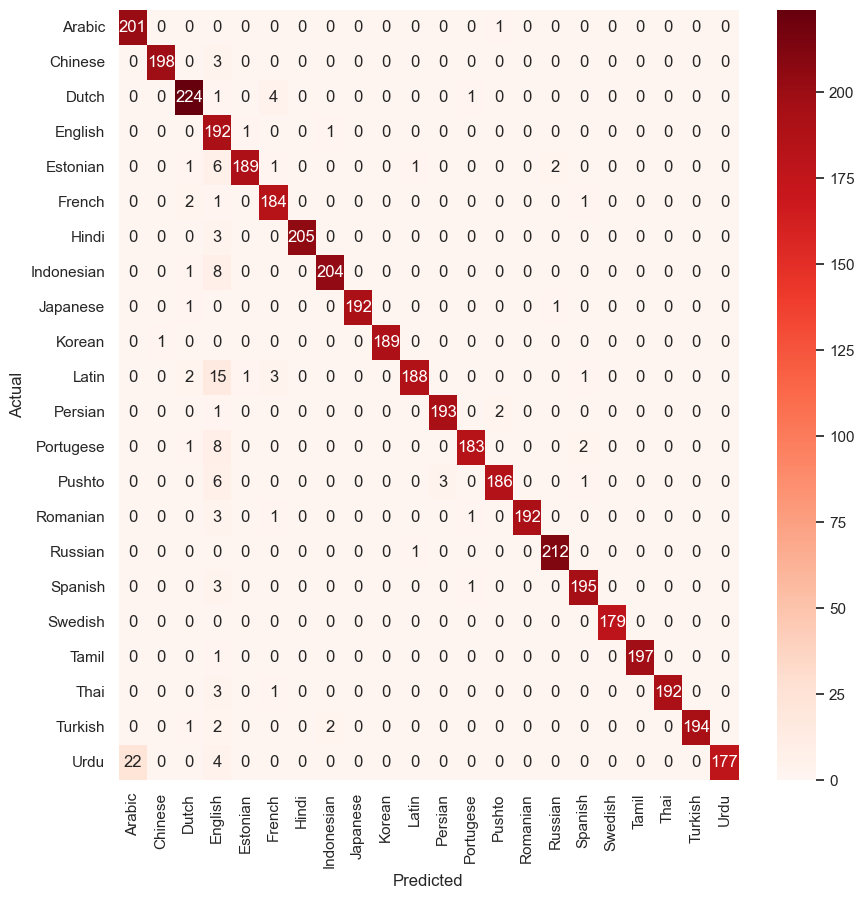

Chọn nguồn nhập liệu:
1. Văn bản đầu vào
2. Tệp DOCX
3. Tệp PDF
4. URL


Nhập lựa chọn của bạn (1/2/3/4):  1
Nhập văn bản cần phân loại:  hello


Ngôn ngữ dự đoán: English


In [2]:
# Nhập các thư viện cần thiết
import pandas as pd
import re
import numpy as np
import os
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sn
import matplotlib.pyplot as plt
from docx import Document
import fitz  # PyMuPDF

# Đọc dữ liệu từ tập tin CSV
raw = pd.read_csv('C:/Users/GIGABYTE/Downloads/dataset.csv')
X = raw['Text']
y = raw['language']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Định nghĩa lớp tiền xử lý
class TextCleaner(BaseEstimator, TransformerMixin):
    def clean_text(self, text):
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [self.clean_text(text) for text in X]

# Tạo một pipeline
pipeline = Pipeline([
    ('text_cleaner', TextCleaner()),  # Bước làm sạch văn bản
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 2), min_df=1e-2)),  # Vector hóa
    ('classifier', MultinomialNB())  # Mô hình phân loại
])

# Huấn luyện mô hình
pipeline.fit(X_train, y_train)

# Dự đoán và đánh giá mô hình
y_predict = pipeline.predict(X_test)

# Tính toán và in ra điểm số F1
def plot_F_Scores(y_test, y_predict):
    f1_micro = f1_score(y_test, y_predict, average='micro')
    f1_macro = f1_score(y_test, y_predict, average='macro')
    f1_weighted = f1_score(y_test, y_predict, average='weighted')
    print("F1: {} (micro), {} (macro), {} (weighted)".format(f1_micro, f1_macro, f1_weighted))

# Vẽ ma trận Confusion
def plot_Confusion_Matrix(y_test, y_predict, color="Blues"):
    allLabels = list(set(list(y_test) + list(y_predict)))
    allLabels.sort()
    confusionMatrix = confusion_matrix(y_test, y_predict, labels=allLabels)
    df_cm = pd.DataFrame(confusionMatrix, columns=allLabels, index=allLabels)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sn.set(font_scale=0.8)
    sn.set(rc={'figure.figsize': (10, 10)})
    sn.heatmap(df_cm, cmap=color, annot=True, fmt='g')
    plt.show()

# In điểm số F1 và ma trận Confusion
plot_F_Scores(y_test, y_predict)
plot_Confusion_Matrix(y_test, y_predict, "Reds")

# Định nghĩa hàm chính
def main():
    print("Chọn nguồn nhập liệu:")
    print("1. Văn bản đầu vào")
    print("2. Tệp DOCX")
    print("3. Tệp PDF")
    print("4. URL")
    
    choice = input("Nhập lựa chọn của bạn (1/2/3/4): ")
    
    cleaned_input = ""  # Khởi tạo biến cleaned_input

    if choice == '1':
        input_text = input("Nhập văn bản cần phân loại: ")
        cleaned_input = input_text  # Chỉ cần văn bản

    elif choice == '2':
        file_path = input("Nhập đường dẫn đến tệp DOCX: ")
        doc = Document(file_path)
        cleaned_input = '\n'.join([para.text for para in doc.paragraphs])
        
    elif choice == '3':
        file_path = input("Nhập đường dẫn đến tệp PDF: ")
        pdf_text = []
        with fitz.open(file_path) as pdf:
            for page in pdf:
                pdf_text.append(page.get_text())
        cleaned_input = '\n'.join(pdf_text)
        
    elif choice == '4':
        url = input("Nhập URL: ")
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        cleaned_input = ' '.join([p.get_text() for p in soup.find_all(['p', 'h1', 'h2', 'h3', 'li'])])
        
    else:
        print("Lựa chọn không hợp lệ.")
        return
    
    # Dự đoán ngôn ngữ
    predicted_language = pipeline.predict([cleaned_input])  # Duy trì danh sách để pipeline có thể xử lý
    print("Ngôn ngữ dự đoán:", predicted_language[0])
    
    # Lưu kết quả vào lịch sử
    save_prediction_history("Input type: " + choice, predicted_language[0])

def save_prediction_history(source_name, predicted_language):
    file_path = r"C:\Users\GIGABYTE\OneDrive\Máy tính\quản trị dự án\history.csv"
    
    if os.path.exists(file_path):
        history_df = pd.read_csv(file_path)
    else:
        history_df = pd.DataFrame(columns=['Source', 'Predicted Language'])
    
    new_record = {
        'Source': source_name,
        'Predicted Language': predicted_language
    }
    
    history_df = pd.concat([history_df, pd.DataFrame([new_record])], ignore_index=True)
    history_df.to_csv(file_path, index=False)

# Gọi hàm chính
if __name__ == "__main__":
    main()


In [3]:
import streamlit as st
from sklearn.pipeline import Pipeline
import pandas as pd
from docx import Document
import fitz  # PyMuPDF
import requests
from bs4 import BeautifulSoup
import os

# Đường dẫn file lịch sử dự đoán
history_file_path = r"C:\Users\GIGABYTE\OneDrive\Máy tính\quản trị dự án\history.csv"

# Hàm để ghi kết quả vào file lịch sử
def save_prediction_history(source_name, predicted_language):
    if os.path.exists(history_file_path):
        history_df = pd.read_csv(history_file_path)
    else:
        history_df = pd.DataFrame(columns=['Source', 'Predicted Language'])
    
    new_record = {'Source': source_name, 'Predicted Language': predicted_language}
    history_df = pd.concat([history_df, pd.DataFrame([new_record])], ignore_index=True)
    history_df.to_csv(history_file_path, index=False)

# Hàm đọc file DOCX
def load_text_from_docx(file_path):
    doc = Document(file_path)
    return '\n'.join([para.text for para in doc.paragraphs])

# Hàm đọc file PDF
def load_text_from_pdf(file_path):
    pdf_text = []
    with fitz.open(file_path) as pdf:
        for page in pdf:
            pdf_text.append(page.get_text())
    return '\n'.join(pdf_text)

# Hàm đọc nội dung từ URL
def load_text_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Kiểm tra nếu yêu cầu gặp lỗi
        soup = BeautifulSoup(response.content, 'html.parser')
        return ' '.join([p.get_text() for p in soup.find_all(['p', 'h1', 'h2', 'h3', 'li'])])
    except requests.exceptions.RequestException as e:
        st.error(f"Không thể truy cập URL. Vui lòng kiểm tra lại URL. Chi tiết lỗi: {e}")
        return None

# Giao diện ứng dụng
st.title("Ứng dụng Xác định Ngôn ngữ")

input_type = st.selectbox("Chọn loại đầu vào", ("Text", "DOCX File", "PDF File", "URL"))

if input_type == "Text":
    input_text = st.text_area("Nhập văn bản tại đây:")
    if st.button("Dự đoán ngôn ngữ"):
        if input_text.strip():
            predicted_language = pipeline.predict([input_text])[0]
            st.success(f"Ngôn ngữ dự đoán: {predicted_language}")
            save_prediction_history("Text Input", predicted_language)
        else:
            st.warning("Vui lòng nhập văn bản trước khi nhấn 'Dự đoán ngôn ngữ'.")

elif input_type == "DOCX File":
    uploaded_file = st.file_uploader("Tải lên tệp DOCX", type="docx")
    if st.button("Dự đoán ngôn ngữ"):
        if uploaded_file:
            text = load_text_from_docx(uploaded_file)
            predicted_language = pipeline.predict([text])[0]
            st.success(f"Ngôn ngữ dự đoán: {predicted_language}")
            save_prediction_history("DOCX File", predicted_language)
        else:
            st.warning("Vui lòng tải lên một tệp DOCX để phân tích.")

elif input_type == "PDF File":
    uploaded_file = st.file_uploader("Tải lên tệp PDF", type="pdf")
    if st.button("Dự đoán ngôn ngữ"):
        if uploaded_file:
            text = load_text_from_pdf(uploaded_file)
            predicted_language = pipeline.predict([text])[0]
            st.success(f"Ngôn ngữ dự đoán: {predicted_language}")
            save_prediction_history("PDF File", predicted_language)
        else:
            st.warning("Vui lòng tải lên một tệp PDF để phân tích.")

elif input_type == "URL":
    url = st.text_input("Nhập URL:")
    if st.button("Dự đoán ngôn ngữ"):
        if url.strip():
            text = load_text_from_url(url)
            if text:  # Kiểm tra nếu URL có thể truy cập được và có văn bản
                predicted_language = pipeline.predict([text])[0]
                st.success(f"Ngôn ngữ dự đoán: {predicted_language}")
                save_prediction_history("URL", predicted_language)
        else:
            st.warning("Vui lòng nhập một URL hợp lệ trước khi nhấn 'Dự đoán ngôn ngữ'.")

# Phần kiểm tra lịch sử dịch thuật
st.subheader("Lịch sử Dự đoán")
if os.path.exists(history_file_path):
    history_df = pd.read_csv(history_file_path)
    st.dataframe(history_df)  # Hiển thị lịch sử dưới dạng bảng
else:
    st.info("Chưa có lịch sử dự đoán.")


2024-11-11 15:42:16.242 
  command:

    streamlit run C:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-11-11 15:42:16.243 Session state does not function when running a script without `streamlit run`
